# Purines, Pyrimidines, and Convolutional Neural Networks
> A sketch of CNNs for homotypic motif density localization (finding clusters of the same type of sequence motif).

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]


# Background

*This notebook is adapted from the CS-185, Spring 2021 course at Brown University* (http://cs.brown.edu/courses/csci1850)

## Biology

Transcription Factors (TFs) are an important class of protein that bind to sections of DNA. This binding process is mediated by their propensity to attach to particular sequence motifs, or patterns in the DNA sequence. Often, we humans refer to binding as important regulatory regions, as associated transcription factors play a large role in upregulating and/or downregulating sequence transcription. In other words, finding the location of such motifs on a given sequence allows us to glean a functional understanding from structure alone. If an algorithm can be trained to detect relevant motifs given a cluster with high fidelity, then the algorithm could obviate hand-tuned feature identification, and even predict likely TF binding sites from unknown sequences. In fact, this is the exact problem we will solve in this exercise.

## Dataset 

The small dataset provided actually is *simulated* homotypic motif density localization data. For more about how to generate such data, see the Kundaje Lab's DragoNN (http://kundajelab.github.io/dragonn/), and if you want, try to beat their results with, perhaps, the GAN from my previous post 😉. The nice thing about this dataset is that it is already formatted for easy loading. Each "sequence" is actually a $1500-mer$, and, given their *in silico* provenance, we can assume 🌟 perfect coverage 🌟 and 🌸 no sequencing errors 🌸 for the purpose of this exercise. We can take a peek at the training split below.

In [1]:
# !wget http://cs.brown.edu/courses/csci1850/homeworks/hw1/hw1_data.npz

#Get the data.

In [2]:
import numpy as np
import pandas as pd
data=np.load('./data_dna_cnn/hw1_data.npz')
train_seq = data['train_seq']
train_y = data['train_y']
train_df = pd.DataFrame([train_seq,train_y]).T.rename(columns=dict(zip([0,1],['X','y'])))
train_df.head(10)

,X,y
0,TGTTACGCTATCGCGAACAGTATGTTCAAGTGGGCGTTCGCTAGGA...,[True]
1,CAAACTTCTTCAAAGGATCCCAGATGCGGTTAAATCATACCACCAA...,[True]
2,GACCATGCCTTGAGGCGTATACATTTGTTGTAGTTGAATTACTACG...,[True]
3,AGTATTACGATCATAGAGTATCAGAGTTGTTTTGTAACAGCGTCGG...,[False]
4,CTTCAGATACGTAATTACTCTATAATTTACAAACAACCACGTATCC...,[False]
5,AGGAGTTTCTATTTCAGAAGTGAACGGTGACAAAAAGTCCACTCAA...,[True]
6,GGGTCGAAAAGTATGACGATCCAATCATTAGAAGTGAGGTTCACCT...,[False]
7,AATATTTAATTTATCTCCGACCAGTCAAAGATACTGTCTTGAACTG...,[True]
8,GGCGCCTTTTTTCTCAAAAGAAAGTGATGTTGTTTTGCATTTCTAT...,[True]
9,TCGCCGGATGGACTGCTACCTTGTTGGACTAATGGTATATTTTTCC...,[True]


In [3]:
np.unique([len(x) for x in train_df.X])

array([1500])

<AxesSubplot:title={'center':'True     2010\nFalse    1990\nName: y, dtype: int64'}, ylabel='Frequency'>

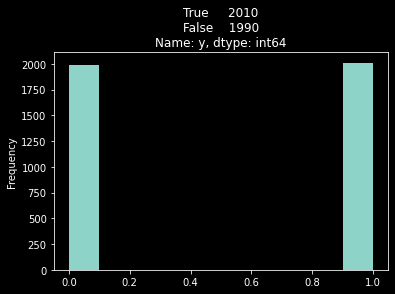

In [4]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
train_df.y.astype(int).plot(kind='hist',title=f'{train_df.y.astype(bool).value_counts()}')

We see an equal distribution of positive (`True`) and negative (`False`) $1500$-mer training instances (a nice thing to have, but not something we can necessarily count on in the real world!). In fact, the same class proportion and sequence length holds true for the test and validation splits (the former being especially unlikely).

## Machine Learning

We aim to build a classifer to predict functional motifs given sequences. Formally, we learn a function $f(X)=\vec{y}$ that, given the nature of deep learning networks, fits with non-linearity a probability density function $f=P(y|X;\theta)$. The task is to learn a weights matrix $W\subset \theta$ (a subset since our network may be more complicated) approximating the true class posterior distribution, such that when we call $f(x_{novel})$, we get $\hat{y}\approx y_{true}$, where $y\in \{0,1\} = \{\text{motif,non-motif}\}$. 

### Task:
We aim to train a CNN to classify the sequences as positive or negative for homotypic motif clusters. A CNN should be a good choice due to the natural shift-invariance of the architecture. When used on images, CNNs are feature-aware but, importantly, location-agnostic. We want the same approach to motif finding since such subsequences may appear anywhere in the $1500$-mer instances.

One-Hot Basic CNN:

        - CNNs on static one-hot embedded nucleotides.
        - 1 Convolution layer (+ nonlinearity + pooling) and 1 dense (`linear` + activation) output layer.
        - Shift-invariance of the CNN is the main point here.
        - Train the model using stochastic gradient descent and binary cross-entropy loss.

Embedding with CNN:
        
        - Use of a learnable embedding on integer-mapped DNA sequences together with the same downstream architecture.

Transformer:
        
        - Akin to NLP, we can treat each nucelotide like a token in a sentence.
        - Train an XLNet (with self-attention and all the rest) model with a linear head to predict presence (0/1) of motifs.
        - This particular model is useful since we have somewhat lengthy instances for a transformer (1500-mers).

I will begin by defining the requisite PyTorch `Dataset` and `Dataloader` classes, as well as an extensible `LightningModule` for use across models.

In [5]:
# !pip install pytorch-lightning

In [6]:
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from transformers import AutoConfig, AutoModelForSequenceClassification #the latter includes a linear head.

The `Dataset` class is now defined with associated preprocessing methods:

In [7]:
class DNADataset(Dataset):
    """DNA / Pytorch dataset."""
    def __init__(self, X, y, encoding='one-hot'):
        """
        Args:
            data (np.array): Path to the url .npz file with annotations.
        """
        
        self.X = torch.FloatTensor(self.one_hot_encoding(X)) if encoding=='one-hot' else torch.LongTensor(self.embedding_encoding(X))
        self.y = torch.FloatTensor(y)
            #NOTE: we need this to be a float to accommodate nn.BCEWithLogitsLoss() later to match logit input.

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {'X': self.X[idx], 'y': self.y[idx]}
        return sample

    def one_hot_encoding(self,seq_array:np.ndarray) -> np.ndarray:
        """
        :param seq_array: np array of DNA sequences
        :return: np array of one-hot encodings of input DNA sequences of shape N,S,M,
                where N is the number of instances, S is the cardinality of the corpus,
                and M is the length of each sequence.
        """
        nuc2id = {'A' : 0, 'C' : 1, 'T' : 2, 'G' : 3}

        N = len(seq_array)
        S = len(nuc2id.keys())
        M = len(seq_array[0]) #since we know each sequence is the same length

        onehot_array = np.zeros((N, S, M))
        
        print('Nucelotides -> One-Hot')
        for seq_num, seq in enumerate(seq_array):
            for seq_idx, nucleotide in enumerate(seq):
                nuc_idx = nuc2id[nucleotide]
                onehot_array[seq_num, nuc_idx, seq_idx] = 1

        return onehot_array

    def embedding_encoding(self, seq_array: np.ndarray) -> np.ndarray:
        """
        :param seq_array: np array of DNA sequences
        :return: np array of integer encodings of input DNA sequences
        """
        nuc2id = {'A' : 0, 'C' : 1, 'T' : 2, 'G' : 3}
        N = len(seq_array)
        M = len(seq_array[0]) #since we know each sequence is the same length

        int_array = np.full((N,M),0)
        print('Nucleotides -> Integers')
        for seq_num, seq in enumerate(seq_array):
            for seq_idx, nucleotide in enumerate(seq):
                nuc_idx = nuc2id[nucleotide]
                int_array[seq_num, seq_idx] = nuc2id[nucleotide]
        return int_array

class DNADataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str, batch_size:int=64,encoding='one-hot'):
        super().__init__()
        self.batch_size = batch_size
        self.data_fpath = data_dir
        self.encoding=encoding

    def setup(self, stage=None):
        all_data = np.load(self.data_fpath)

        self.train = DNADataset(all_data['train_seq'],all_data['train_y'],self.encoding)
        self.val   = DNADataset(all_data['train_seq'],all_data['train_y'],self.encoding)
        self.test  = DNADataset(all_data['test_seq'], all_data['test_y'], self.encoding)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)

In [8]:
dm_onehot = DNADataModule(data_dir='./data_dna_cnn/hw1_data.npz',encoding='one-hot')
dm_onehot.setup()
dm_int = DNADataModule(data_dir='./data_dna_cnn/hw1_data.npz',encoding='int') #for use with 2nd CNN and Transformer
dm_int.setup()

Nucelotides -> One-Hot
Nucelotides -> One-Hot
Nucelotides -> One-Hot
Nucleotides -> Integers
Nucleotides -> Integers
Nucleotides -> Integers


## Model Instantiation

We can now define models to be instantiated in the main Pytorch ```LightningModule```.

### Basic CNN

Again, we define a convolutional neural net on static, one-hot embedded nucleotides. For now, I will use a single 1-Dimensional Convolution layer (+ nonlinearity + flattening) and one dense (`linear` + activation) output layer. This model will make use of the `dm_onehot` data module defined and instantiated above.

As you might remember from above, we one-hot encoded each sequence using a dictionay of nucleotides to integers, and then encoded a 4-channel NumPy binary array using the indices of this dictionary. When placed into the dataset class with a batch-size parameter, we can finally see what the network sees per "minibatch" of sequences. I say "minibatch" because technically each shuffled pass during a stochastic gradient descent epoch is commonly referred to as a batch.

Please see https://colab.research.google.com/github/Avsecz/DL-genomics-exercise/blob/master/Simulated.ipynb#scrollTo=MYVEEl0zZwlr for the Keras model I've based my implementation on.

At any rate, the model views a tensor from the dataloader of the following shape (note this is also a nice way to access a sample instance from the dataloader directly):

In [9]:
x_sample_onehot = next(iter(dm_onehot.test_dataloader()))['X']
x_sample_onehot

tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.]],

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 0.,  ..., 0., 1., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 1., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 1.]],

        [[0., 1., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 1., 1., 0.],
         [0., 0., 0.,  ..., 0., 0

In [10]:
x_sample_onehot.shape #batch_size, channels, length

torch.Size([64, 4, 1500])

So, we have a fixed one-hot tensor of shape $(N,C,L)$, just like the Pytorch `nn.Conv1d` will expect. Note that we use $1$-D here since we have sequential data.


In [11]:
class DNACNN(nn.Module):
    def __init__(self):
        super(DNACNN, self).__init__()
        self.net=nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=16, kernel_size=16), # -> [64, 16, 1485]
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(16), #-> [64, 16, 16]
            nn.Flatten(), #-> [64,256]
            nn.Linear(256,1), # -> [64,1] , a single logit output per instance.
            # nn.Sigmoid() -> no need for final activation since we will use nn.BCEWithLogitsLoss()
        )

    def forward(self, x):
        x = self.net(x)
        return x

### CNN with Trainable Embeddings

Now, for the embedding case, I will essentially "recreate" a learnable one-hot embedding. That is, we can directly compare the outcome of a learnable `nn.embedding` versus a fixed one-hot vector per sequence minibatch by being creative with dimensions.


In [12]:
x_sample_int = next(iter(dm_int.test_dataloader()))['X']
x_sample_int.shape #batch_size, channels, length

torch.Size([64, 1500])

In [13]:
x_sample_int_embedded = nn.Embedding(num_embeddings=64, embedding_dim=4)(x_sample_int).view(64,4,1500)
x_sample_int_embedded.shape

torch.Size([64, 4, 1500])

Note that this looks identical to the one-hot encoding. However, we can take a look at the values:

In [14]:
x_sample_int_embedded

tensor([[[ 0.4570, -2.0863,  1.1360,  ..., -0.5568,  0.0075, -0.0272],
         [ 0.4570, -2.0863,  1.1360,  ...,  1.5261,  0.5930,  1.0185],
         [ 0.4570, -2.0863,  1.1360,  ..., -2.0863,  1.1360, -0.5638],
         [ 0.0159, -1.1691,  1.2557,  ..., -0.5568,  0.0075, -0.0272]],

        [[ 0.1240, -0.5568,  0.0075,  ..., -0.5568,  0.0075, -0.0272],
         [ 0.4570, -2.0863,  1.1360,  ..., -0.5568,  0.0075, -0.0272],
         [-0.9929,  1.5261,  0.5930,  ..., -2.0863,  1.1360, -0.5638],
         [-0.9929,  1.5261,  0.5930,  ..., -1.1691,  1.2557, -0.1304]],

        [[-0.9929,  1.5261,  0.5930,  ..., -1.1691,  1.2557, -0.1304],
         [ 0.4570, -2.0863,  1.1360,  ..., -2.0863,  1.1360, -0.5638],
         [-0.9929,  1.5261,  0.5930,  ...,  1.5261,  0.5930,  1.0185],
         [ 0.1240, -0.5568,  0.0075,  ..., -2.0863,  1.1360, -0.5638]],

        ...,

        [[ 0.1240, -0.5568,  0.0075,  ...,  1.5261,  0.5930,  1.0185],
         [ 0.4570, -2.0863,  1.1360,  ..., -1.1691,  1.25

Note that the tensor is initially randomized float values. But, unlike the one-hot case, these values (this lookup table) will be *trained/adjusted during backpropagation*!

In [15]:
class DNACNNEmbedding(nn.Module):
    def __init__(self):
        super(DNACNNEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=64, embedding_dim=4)
        self.net=nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=16, kernel_size=16), # -> [64, 16, 1485]
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(16), #-> [64, 16, 16]
            nn.Flatten(), #-> [64,256]
            nn.Linear(256,1), # -> [64,1] , a single logit output per instance.
            # nn.Sigmoid() -> no need for final activation since we will use nn.BCEWithLogitsLoss()
        )

    def forward(self, x):
        y = self.net(self.embedding(x).view(64,4,1500))
        return y

### The DNA Transformer!

Let's create a class using HuggingFace within an nn.module.


Note that for the Transformer, I will be pulling an *untrained* model from Huggingface. That involves invoking the `config` of the desired model, but instantiating the model itself from the config only (***not*** `from_pretrained`). I think this is actually quite annoying and could warrant a pull request at a future date (there ought to be a flag like `.from_untrained`).

As for the tokenizer, we don't really need the actual model's tokenizer with associated vocabulary, etc., since we can just map each nucleotide to an integer. This should be equivalent to character-level tokenization of each nucleotide with an untrained vocabulary, but also allowed for the use of `nn.Embedding()` for the second CNN (detailed above).

For illustrative purposes:

In [16]:
model = AutoModelForSequenceClassification.from_config(
    AutoConfig.from_pretrained('xlnet-base-cased')
    )
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

The transformer model is currently instantiated for classification (`model.logits_proj` has `out_features=2`). Note that we will need to take some form of activation across these logits (sigmoid, or even plain argmax). We can use `BCEWithLogits` (binary cross entropy with logits) to accomplish this.

Note due to the nature of binary (versus multlabel) classification, that we could instead have a *single* neuron output and use sigmoidal activation (analagous to logistic regression).

The key difference here is that a single neuronal output will evaluate the probability of a single output together, rather than the probability of each class independently. By keeping the output dimensions as $2$, we may gain a small amount out capacity of the network (each output gets its own weight) that would be implicit otherwise. More formally, the VC dimension of a parameter-rich network is greater, however small.

Still, the dimensions of the label space need to pairwise match. Since labels are currently set up in the dataset with cardinality of 1 (scalar, versus a one-hot or other label encoding of its own), I will instead just refactor the model slightly to have a single output dimension. It's not clear what the advantage in this toy example would be to changing or keeping this tiny aspect of the architecture would be, at any rate.



In [17]:
model.logits_proj = nn.Linear(in_features=768,out_features=1,bias=True)
model.logits_proj

Linear(in_features=768, out_features=1, bias=True)

Perfect! This will be incorporated below.

In short, this step allows us to create a black-box network while keeping all of the business of training each of these three models as similar as possible (same loss, same `LightningModule`, etc., and I'm sure there are even more concise methods).

In [18]:
class DNATransformer(nn.Module):
    def __init__(self,transformer_checkpoint='xlnet-base-cased'):
        super(DNATransformer, self).__init__()
        
        #Load untrained model using checkpointed config.
        self.config = AutoConfig.from_pretrained(transformer_checkpoint)
        self.model = AutoModelForSequenceClassification.from_config(self.config)
        self.model.logits_proj = nn.Linear(in_features=768,out_features=1,bias=True)

    def forward(self,x):
        return self.model(x)

### Integration: The Training Module

Now, the three models defined above are ready to be invoked into during train, test, and inference. We can organize this under a `LightningModule`:

In [19]:
class DNALitModule(pl.LightningModule):

    def __init__(self,net:nn.Module):
        super().__init__()
        self.net = net
        self.criterion = nn.BCEWithLogitsLoss() #Sigmoid-->BCE Loss included.

    def training_step(self, batch, batch_idx):
        # --------------------------
        x, y = batch['X'],batch['y']
        y_hat = self.net(x) #take the most probable index.
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss
        # --------------------------

    def validation_step(self, batch, batch_idx):
        # --------------------------
        x, y = batch['X'],batch['y']
        y_hat = self.net(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        # --------------------------

    def test_step(self, batch, batch_idx):
        # --------------------------
        x, y = batch['X'],batch['y']
        y_hat = self.net(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        # --------------------------

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## Training

We are now ready to train the selection of models.

 - Datamodules ✔️

 - CNN ✔️

 - CNN with Embeddings ✔️

 - Transformer ✔️


Time to train!

In [20]:
#for clarity
cnn_dm = dm_onehot
cnn_emb_dm = transformer_dm = dm_int

dna_cnn = DNALitModule(DNACNN())
dna_cnn_emb = DNALitModule(DNACNNEmbedding())
dna_transformer = DNALitModule(DNATransformer())

trainer_cnn = pl.Trainer(fast_dev_run=False,gpus=0,max_epochs=5)
trainer_cnn_emb = pl.Trainer(fast_dev_run=True,gpus=0,max_epochs=5)
trainer_transformer = pl.Trainer(fast_dev_run=True,gpus=0,max_epochs=5)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).


In [21]:
trainer_cnn.fit(model = dna_cnn, datamodule=cnn_dm)


  | Name      | Type              | Params
------------------------------------------------
0 | net       | DNACNN            | 1.3 K 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
Epoch 0:  50%|█████     | 63/126 [00:01<00:01, 42.99it/s, loss=0.693, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 63/126 [00:01<00:01, 46.28it/s, loss=0.686, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 63/126 [00:01<00:01, 46.30it/s, loss=0.638, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 63/126 [00:01<00:01, 46.66it/s, loss=0.509, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 63/126 [00:01<00:01, 47.62it/s, loss=0.37, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 126/126 [00:01<00:00, 69.97it/s, loss=0.37, v_num=2]


1

In [22]:
trainer_cnn_emb.fit(model = dna_cnn_emb, datamodule=cnn_emb_dm)


  | Name      | Type              | Params
------------------------------------------------
0 | net       | DNACNNEmbedding   | 1.6 K 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=0.697]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  8.90it/s, loss=0.697]


1

In [23]:
# trainer_transformer.fit(model=dna_transformer,datamodule=transformer_dm)

These models range in complexity greatly, and my hope is this will serve as a future-proof skeleton for a number of implementations. Other variants of CNNs, RNNs, and other Pytorch objects should be facile to swap and implement, and HuggingFace will likely serve as a choice deep NLP API for some time.

In [24]:
# config = AutoConfig.from_pretrained('xlnet-base-cased')

# model = AutoModelForSequenceClassification.from_config(config)
# model.logits_proj = nn.Linear(in_features=768,out_features=1,bias=True)